<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/R5_Expression_of_Inflammatory_pathway_related_genes_literature_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook id to examine the expression pattern of HATs, HDACs, Inflammatory related and NFkB related pathways in both ES/EB and MEF systems to see if the genes are upregulated or downregulated using a Treatment and control

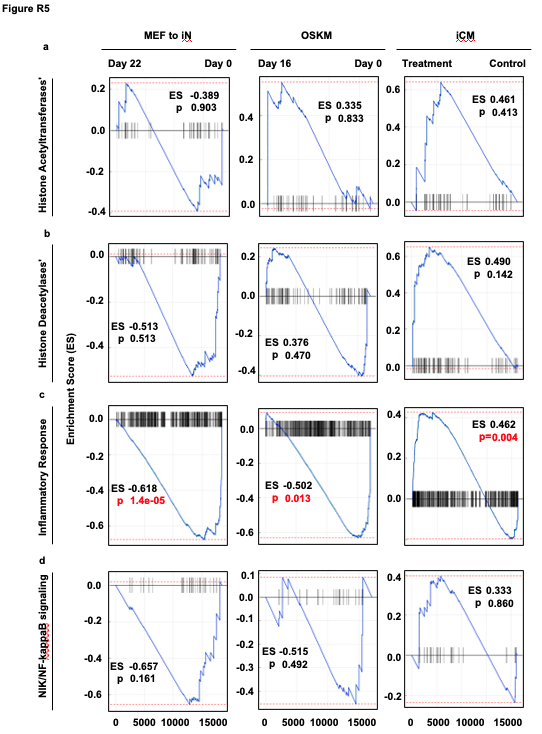

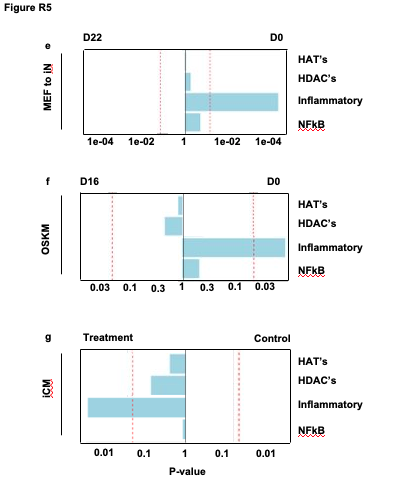

In [ ]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2','clusterProfiler','VennDiagram','fgsea','cowplot','biomaRt', 'forcats'

), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')
devtools::install_github("GSEA-MSigDB/GSEA_R")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'stringr' 'ggplot2' 'forcats'”
Installing package(s) 'BiocVersion', 'SummarizedExperiment', 'rhdf5',
  'SingleCellExperiment', 'limma', 'goseq',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db', 'wordcloud', 'plotrix',
  'DESeq2', 'clusterProfiler', 'VennDiagram', 'fgsea', 'cowplot', 'biomaRt'

also installing the dependencies ‘gridGraphics’, ‘Rhtslib’, ‘rjson’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘ggplotify’, ‘patchwork’, ‘lazyeval’, ‘zlibbioc’, ‘bitops’, ‘Rsamtools’, ‘GenomicAlignments’, ‘restfulr’, ‘plogr’, ‘png’, ‘xtable’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘


✔  checking for file ‘/tmp/RtmpRJlHkt/remotes4f1b98b42f/rstudio-reticulate-277f410/DESCRIPTION’
─  preparing ‘reticulate’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘reticulate_1.22-9000.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




lifecycle (1.0.0 -> 1.0.1) [CRAN]
pillar    (1.6.2 -> 1.6.3) [CRAN]
tibble    (3.1.4 -> 3.1.5) [CRAN]


Installing 3 packages: lifecycle, pillar, tibble

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpRJlHkt/remotes4f224b3c01/GSEA-MSigDB-GSEA_R-8fbd326/DESCRIPTION’
─  preparing ‘GSEA’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘GSEA_1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Loading libraries for R

In [ ]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)
library(GSEA)
library(fgsea)
library(VennDiagram)
library(cowplot)
library(biomaRt)
library(forcats)
library(scales)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

# Loading the gene list obtained from GO containg 4 categories (Hats, HDACs, Inflammatory related and NFkB pathwway related)
https://www.ebi.ac.uk/QuickGO/annotations?goUsage=descendants&goUsageRelationships=is_a,part_of,occurs_in&goId=GO:0004402&taxonId=10090&taxonUsage=descendants

In [ ]:
gene_list <- c(
  "nfkb" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Nf_kB.tsv",
  "hdac" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/HDAC_complex.tsv",
  "hat" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Hat.tsv",
  "inflammatory" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Inflammatory_go.tsv")

In [ ]:
for (i in 1:length(gene_list)){
  sprintf('wget -x -c -nH %s', gene_list[i]) %>% system()
}
gene_list <- gsub('https://s3.msi.umn.edu/', './', gene_list)
message(sprintf('all gene_list exist: %s', all(file.exists(gene_list))))

all gene_list exist: TRUE



In [ ]:
genes <- lapply(gene_list, function(g){read.table(g, header = TRUE, sep = '\t')})

In [ ]:
genes[["hdac_sub"]] <- genes[["hdac"]][grepl('histone', genes[["hdac"]]$GO.NAME),] #Subsetting Histone Deactylase complex

In [ ]:
gene_sets <- lapply(genes, function(x){x$SYMBOL})
names(gene_sets) <- names(genes)

## Load processed scRNA-seq data

In [ ]:
se_file <- c(
  "Liu" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=Liu_version=20210506a/sce.rds",
  "Xing" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=Xing_version=20210506a/sce.rds",
  "Treutlein" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=Treutlein_version=20210506a/sce.rds")

In [ ]:
for (i in 1:length(se_file)){
  sprintf('wget -x -c -nH %s', se_file[i]) %>% system()
}
se_file <- gsub('https://s3.msi.umn.edu/', './', se_file)
message(sprintf('all se_file exist: %s', all(file.exists(se_file))))

all se_file exist: TRUE



In [ ]:
se <- lapply(se_file, function(s){s %>%
  readRDS()})

In [ ]:
se

Loading required package: SingleCellExperiment



$Liu
class: SingleCellExperiment 
dim: 21244 513 
metadata(1): genome
assays(1): counts
rownames(21244): ENSMUSG00000109644 ENSMUSG00000007777 ...
  ENSMUSG00000039068 ENSMUSG00000027596
rowData names(2): ensembl_gene_id symbol
colnames(513): M3_A01 M3_A02 ... C1_H09 C1_H10
colData names(3): sample batch stage

$Xing
class: SingleCellExperiment 
dim: 32738 32138 
metadata(1): genome
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(1): ensembl_gene_id
colnames(32138): AAACCTGAGGAGTTGC.1 AAACCTGAGTACTTGC.1 ...
  TTTGTCACAATGTAAG.6 TTTGTCATCCAAGTAC.6
colData names(3): sample batch stage

$Treutlein
class: SingleCellExperiment 
dim: 18462 405 
metadata(1): genome
assays(1): logcounts
rownames(18462): ENSMUSG00000079144 ENSMUSG00000112095 ...
  ENSMUSG00000039068 ENSMUSG00000027596
rowData names(2): ensembl_gene_id symbol
colnames(405): 1_iN1_C01 1_iN1_C02 ... 715_507_1gg_22d2_C76
  715_508_1n_22d1_C70
colData names(6): s

## scRNA GSEA

## Treutlin dataset - MEF to iN
 Day 22 vs Day 0 Gene set enrichment analysis for HATs, HDACs, Inflammatory abd NFkB

In [ ]:
X <- as.matrix(assays(se$Treutlein)$logcounts)
stage <- colData(se$Treutlein)$stage
stage0 <- stage == 0
stage22 <- stage == 22
pvalues_treutlin <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, stage22], X[i, stage0], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc <- rowMeans(X[, stage22]) - rowMeans(X[, stage0])
names(pvalues_treutlin) <- names(fc) <- rowData(se$Treutlein)$symbol

In [ ]:
res_scrna <- data.frame(
  name = rowData(se$Treutlein)$symbol, 
  fc = fc, 
  pvalue = pvalues_treutlin
)

#Fold Change of genes from MEF to iN

In [ ]:
fc <- res_scrna$fc

In [ ]:
names(fc) <- res_scrna$name

In [ ]:
fc <- na.omit(fc)
fc <- sort(fc, decreasing = TRUE)

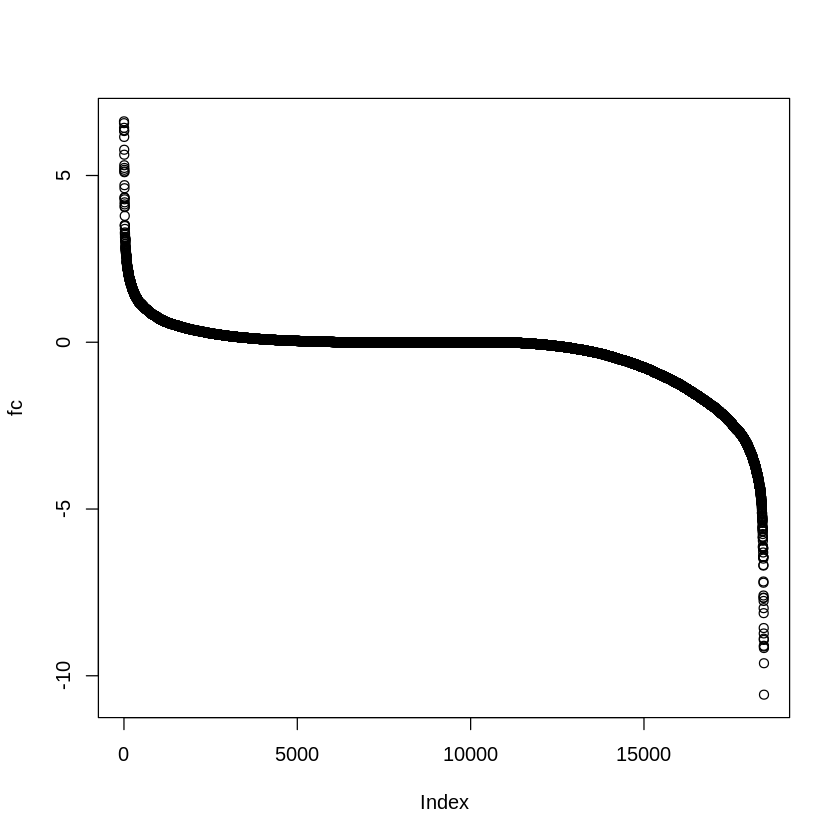

In [ ]:
plot(fc)

## Gene set enrichment analysis 

In [ ]:
set.seed(1)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = fc,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,9.033019e-01,9.033019e-01,0.008823908,-0.3893470,-0.7264569,33,"Hat1 , Taf9 , Msl3 , Naa50 , Gtf2b , Tada2a, Usp22 , Meaf6 , Naa40 , Kat2a , Mcm3ap, Supt7l, Atf2"
hdac,5.134092e-01,8.556820e-01,0.020188684,-0.5129988,-1.0062135,73,"Ruvbl2 , Rbbp7 , Ruvbl1 , Brms1 , Sin3b , Hdac1 , Tbl1x , Anp32e , Znhit1 , Hint1 , Hdac7 , Mta3 , Cbx5 , Sap18 , Mecom , Gatad2a, Dmap1 , Actr6 , Mta2 , Chd4 , Mbd3 , Hdac3 , Ing2 , Hdac8 , Rbbp4 , Hdac2 , Sall1 , Mbd2 , Tbl1xr1, Hdac10 , Sap30l"
hdac_sub,8.395192e-01,9.033019e-01,0.010327592,-0.4242363,-0.8050609,41,"Sin3b , Hdac1 , Tbl1x , Hint1 , Hdac7 , Cbx5 , Sap18 , Mecom , Mta2 , Hdac3 , Hdac8 , Hdac2 , Mbd2 , Tbl1xr1, Hdac10 , Sap30l , Sin3a , Rcor1"
inflammatory,1.438157e-05,7.190786e-05,0.593325476,-0.6181816,-1.2527249,448,"Timp1 , Anxa1 , Cd44 , Thbs1 , Gja1 , Cyba , F3 , Axl , Fn1 , Ccl7 , B4galt1 , F2r , Hmox1 , Ccl2 , Nupr1 , Csf1 , Map2k3 , Ass1 , Ecm1 , Hmgb2 , Ptgs2 , Vcam1 , Loxl3 , Cxcl5 , Sdc1 , Il1r1 , Itgav , Ahcy , Acer3 , Lxn , Snap23 , S1pr3 , Mif , Hmgb1 , Nfe2l2 , Casp6 , Ano6 , Cxcl1 , Aimp1 , Gata3 , Prcp , Ext1 , Lipa , Pparg , Irak2 , Ddx3x , Ly96 , Cspg4 , Plscr1 , Jam3 , Myd88 , Hnrnpa0 , Tnfrsf1a, Plaa , Dhx9 , Ap3b1 , Il4ra , Tcirg1 , Hdac7 , Akt1 , Il1rn , Ppbp , Sphk1 , Adam17 , Ninj1 , Rela , Notch2 , Lias"
nfkb,1.610316e-01,4.025791e-01,0.048856504,-0.6568236,-1.2092298,28,"Ppp4c , Ripk3 , Cops8 , Irak2 , Akt1 , Rela , Tirap , Ikbkg , Irak1 , Traf2 , Nfkb2 , Traf4 , Dicer1, Rel , Map3k7, Chuk"


In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               fc) + labs(title=sprintf('%s: ES %f, p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$ES,fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
  })


In [ ]:
names(ep) <- names(genes)

#MEF to iN

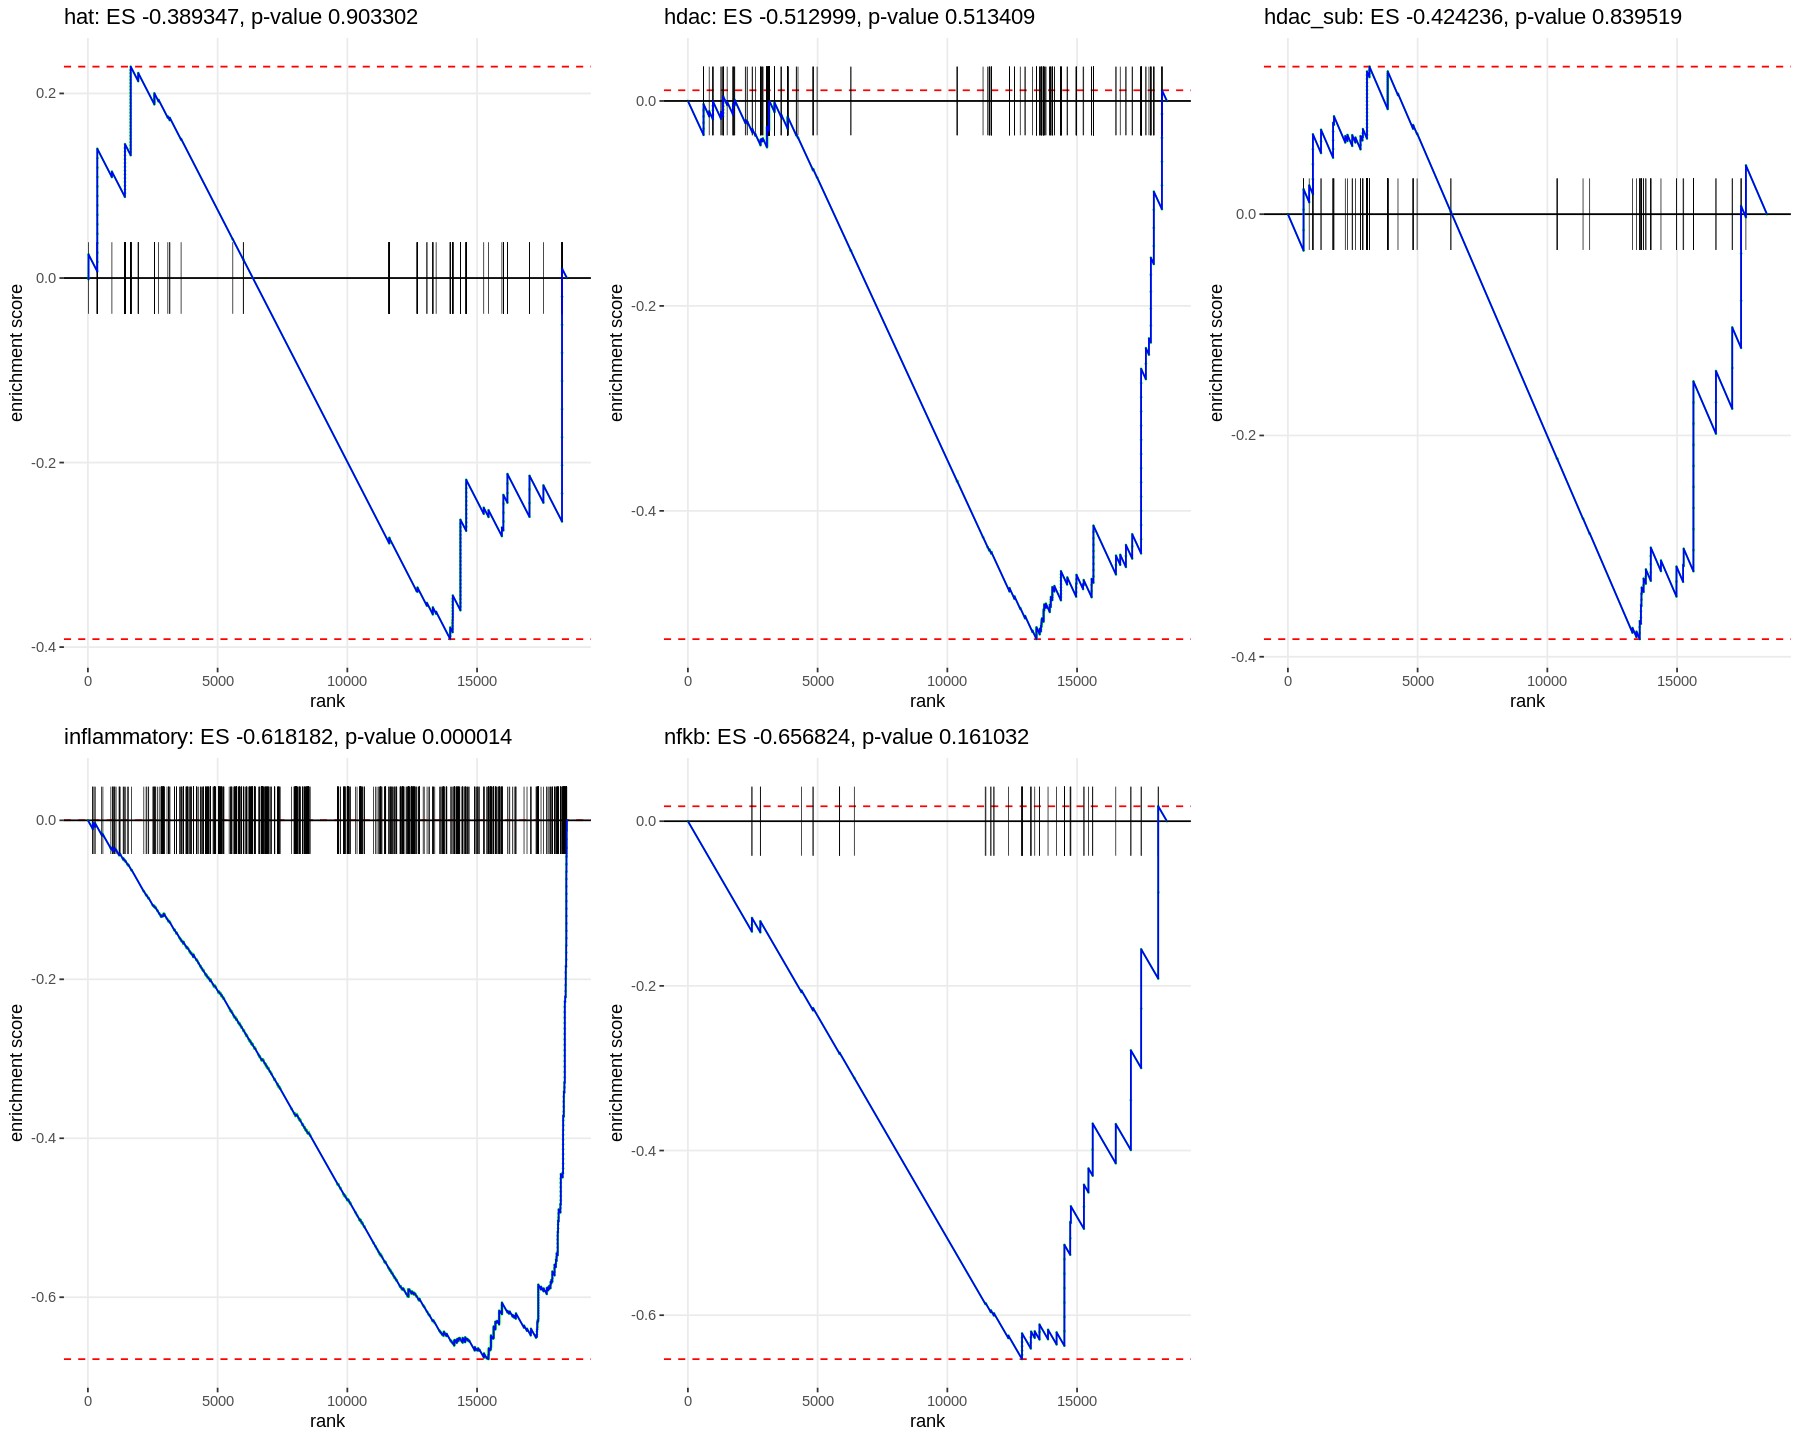

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

## Pvalue of each geneset and the color lightblue here represents negative ES scores 

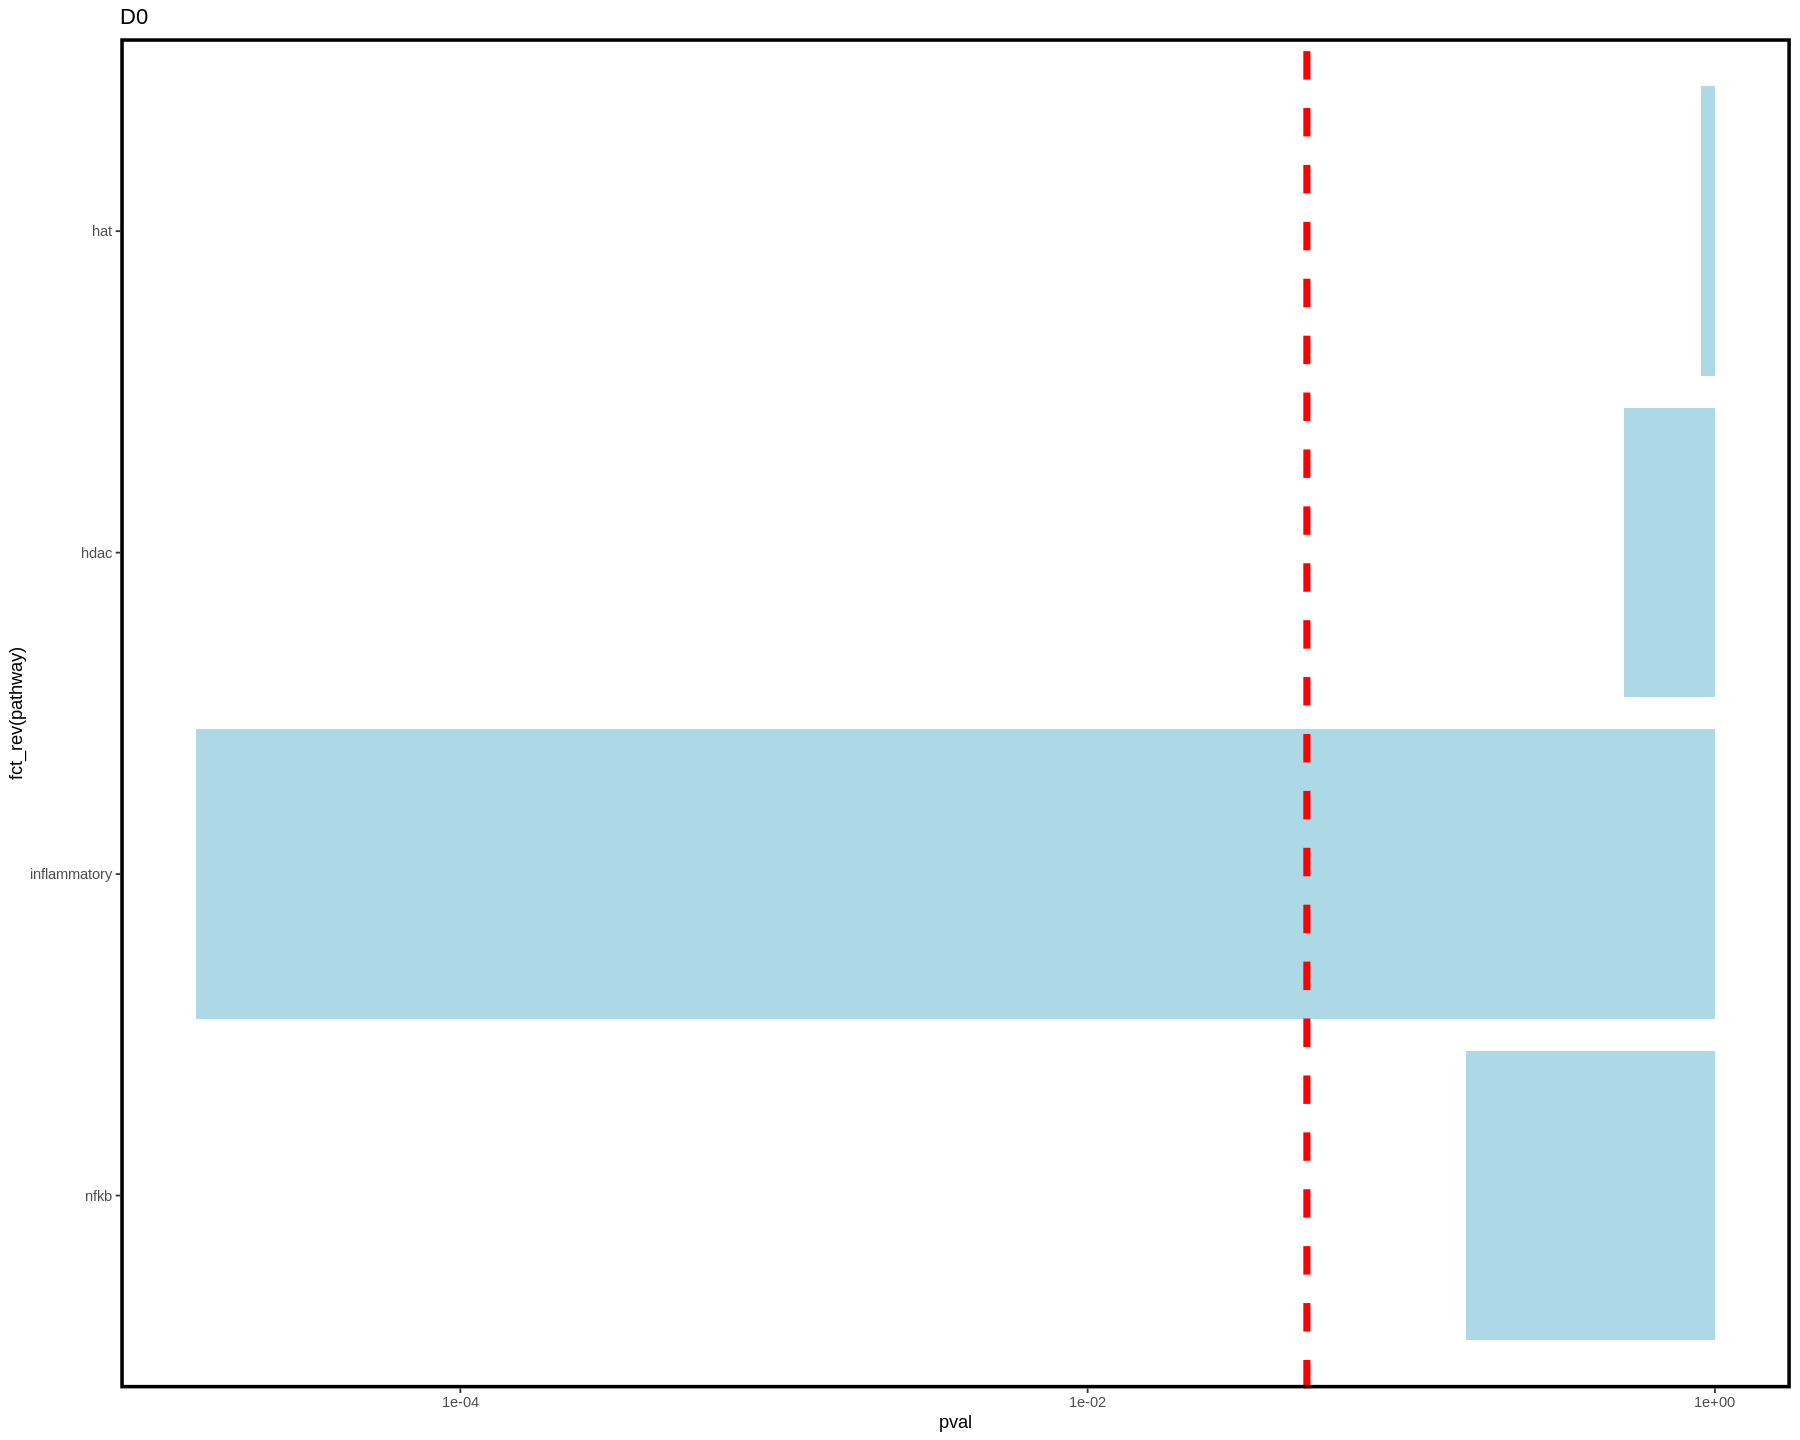

In [ ]:
fgseaRes$ES_score <- ifelse(fgseaRes$ES > 0, "lightcoral", "lightblue")
ggplot(fgseaRes[!grepl('sub', fgseaRes$pathway),],  aes(x = fct_rev(pathway), y = pval, fill = ES_score)) + 
geom_bar(stat = 'identity') + 
coord_flip() +
scale_fill_identity() + 
scale_y_continuous(trans = 'log10',)  + 
geom_hline(yintercept=0.05, color = 'red', linetype='dashed', size = 2) +
 theme_bw() + theme(panel.border = element_rect(colour = 'black', size = 2), panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) +ggtitle('D0')

# Xing Dataset - OSKM 
Day 16 vs Day 0 Geneset enrichment analysis

In [ ]:
norm <- t(t(assays(se$Xing)$counts)/colSums(assays(se$Xing)$counts) * median(colSums(assays(se$Xing)$counts))) 

In [ ]:
assays(se$Xing)$normalized_counts <- norm

In [ ]:
colData(se$Xing)

DataFrame with 32138 rows and 3 columns
                               sample                  batch        stage
                          <character>            <character>  <character>
AAACCTGAGGAGTTGC.1 AAACCTGAGGAGTTGC.1 dataset=Xing_version..           D0
AAACCTGAGTACTTGC.1 AAACCTGAGTACTTGC.1 dataset=Xing_version..           D0
AAACCTGAGTATGACA.1 AAACCTGAGTATGACA.1 dataset=Xing_version..           D0
AAACCTGCACCATGTA.1 AAACCTGCACCATGTA.1 dataset=Xing_version..           D0
AAACCTGCACCTTGTC.1 AAACCTGCACCTTGTC.1 dataset=Xing_version..           D0
...                               ...                    ...          ...
TTTGGTTGTTACGACT.6 TTTGGTTGTTACGACT.6 dataset=Xing_version.. D16_positive
TTTGGTTTCTGTCTCG.6 TTTGGTTTCTGTCTCG.6 dataset=Xing_version.. D16_positive
TTTGGTTTCTTCGGTC.6 TTTGGTTTCTTCGGTC.6 dataset=Xing_version.. D16_positive
TTTGTCACAATGTAAG.6 TTTGTCACAATGTAAG.6 dataset=Xing_version.. D16_positive
TTTGTCATCCAAGTAC.6 TTTGTCATCCAAGTAC.6 dataset=Xing_version.. D16_positiv

In [ ]:
X_1 <- assays(se$Xing)$normalized_counts
stage <- colData(se$Xing)$stage
stage0 <- stage == 'D0'
stage16 <- stage == 'D16_positive'
fc_xing <- log2(rowMeans(X_1[, stage16])+1) - log2(rowMeans(X_1[, stage0])+1)
names(fc_xing) <- rowData(se$Xing)$ensembl_gene_id

In [ ]:
res_xing <- data.frame(
  name = rowData(se$Xing)$ensembl_gene_id, 
  fc1 = fc_xing
)

## Gene names and id from HUMAN to mouse using biomaRt

In [ ]:
human <- useEnsembl("ensembl", dataset = "hsapiens_gene_ensembl")
mouse <- useEnsembl("ensembl", dataset = "mmusculus_gene_ensembl")
ensg <- getLDS(attributes = c("external_gene_name","ensembl_gene_id"),
       filters = "ensembl_gene_id", values = res_xing$name,
       mart = human,
       attributesL = c("ensembl_gene_id","external_gene_name"), 
       martL = mouse)

Ensembl site unresponsive, trying uswest mirror



In [ ]:
res_xing$symbol <- ensg$Gene.name.1[match(res_xing$name, ensg$Gene.stable.ID)]

In [ ]:
res_xing$hgnc <- ensg$Gene.name[match(res_xing$name, ensg$Gene.stable.ID)]

In [ ]:
res_xing <- res_xing[!is.na(res_xing$symbol) & res_xing$symbol != "",]

In [ ]:
head(res_xing)

,name,fc1,symbol,hgnc
,<chr>,<dbl>,<chr>,<chr>
ENSG00000186092,ENSG00000186092,0.0000000000,Olfr1289,OR4F5
ENSG00000187634,ENSG00000187634,-0.6693722172,Samd11,SAMD11
ENSG00000188976,ENSG00000188976,-0.0716301764,Noc2l,NOC2L
ENSG00000187961,ENSG00000187961,-0.0417264484,Klhl17,KLHL17
ENSG00000187583,ENSG00000187583,-0.1245432550,Plekhn1,PLEKHN1
ENSG00000187642,ENSG00000187642,-0.0004547995,Perm1,PERM1


#Fold Change of genes OSKM

In [ ]:
fc1 <- res_xing$fc1

In [ ]:
names(fc1) <- res_xing$symbol

In [ ]:
fc1 <- na.omit(fc1)
fc1 <- sort(fc1, decreasing = TRUE)

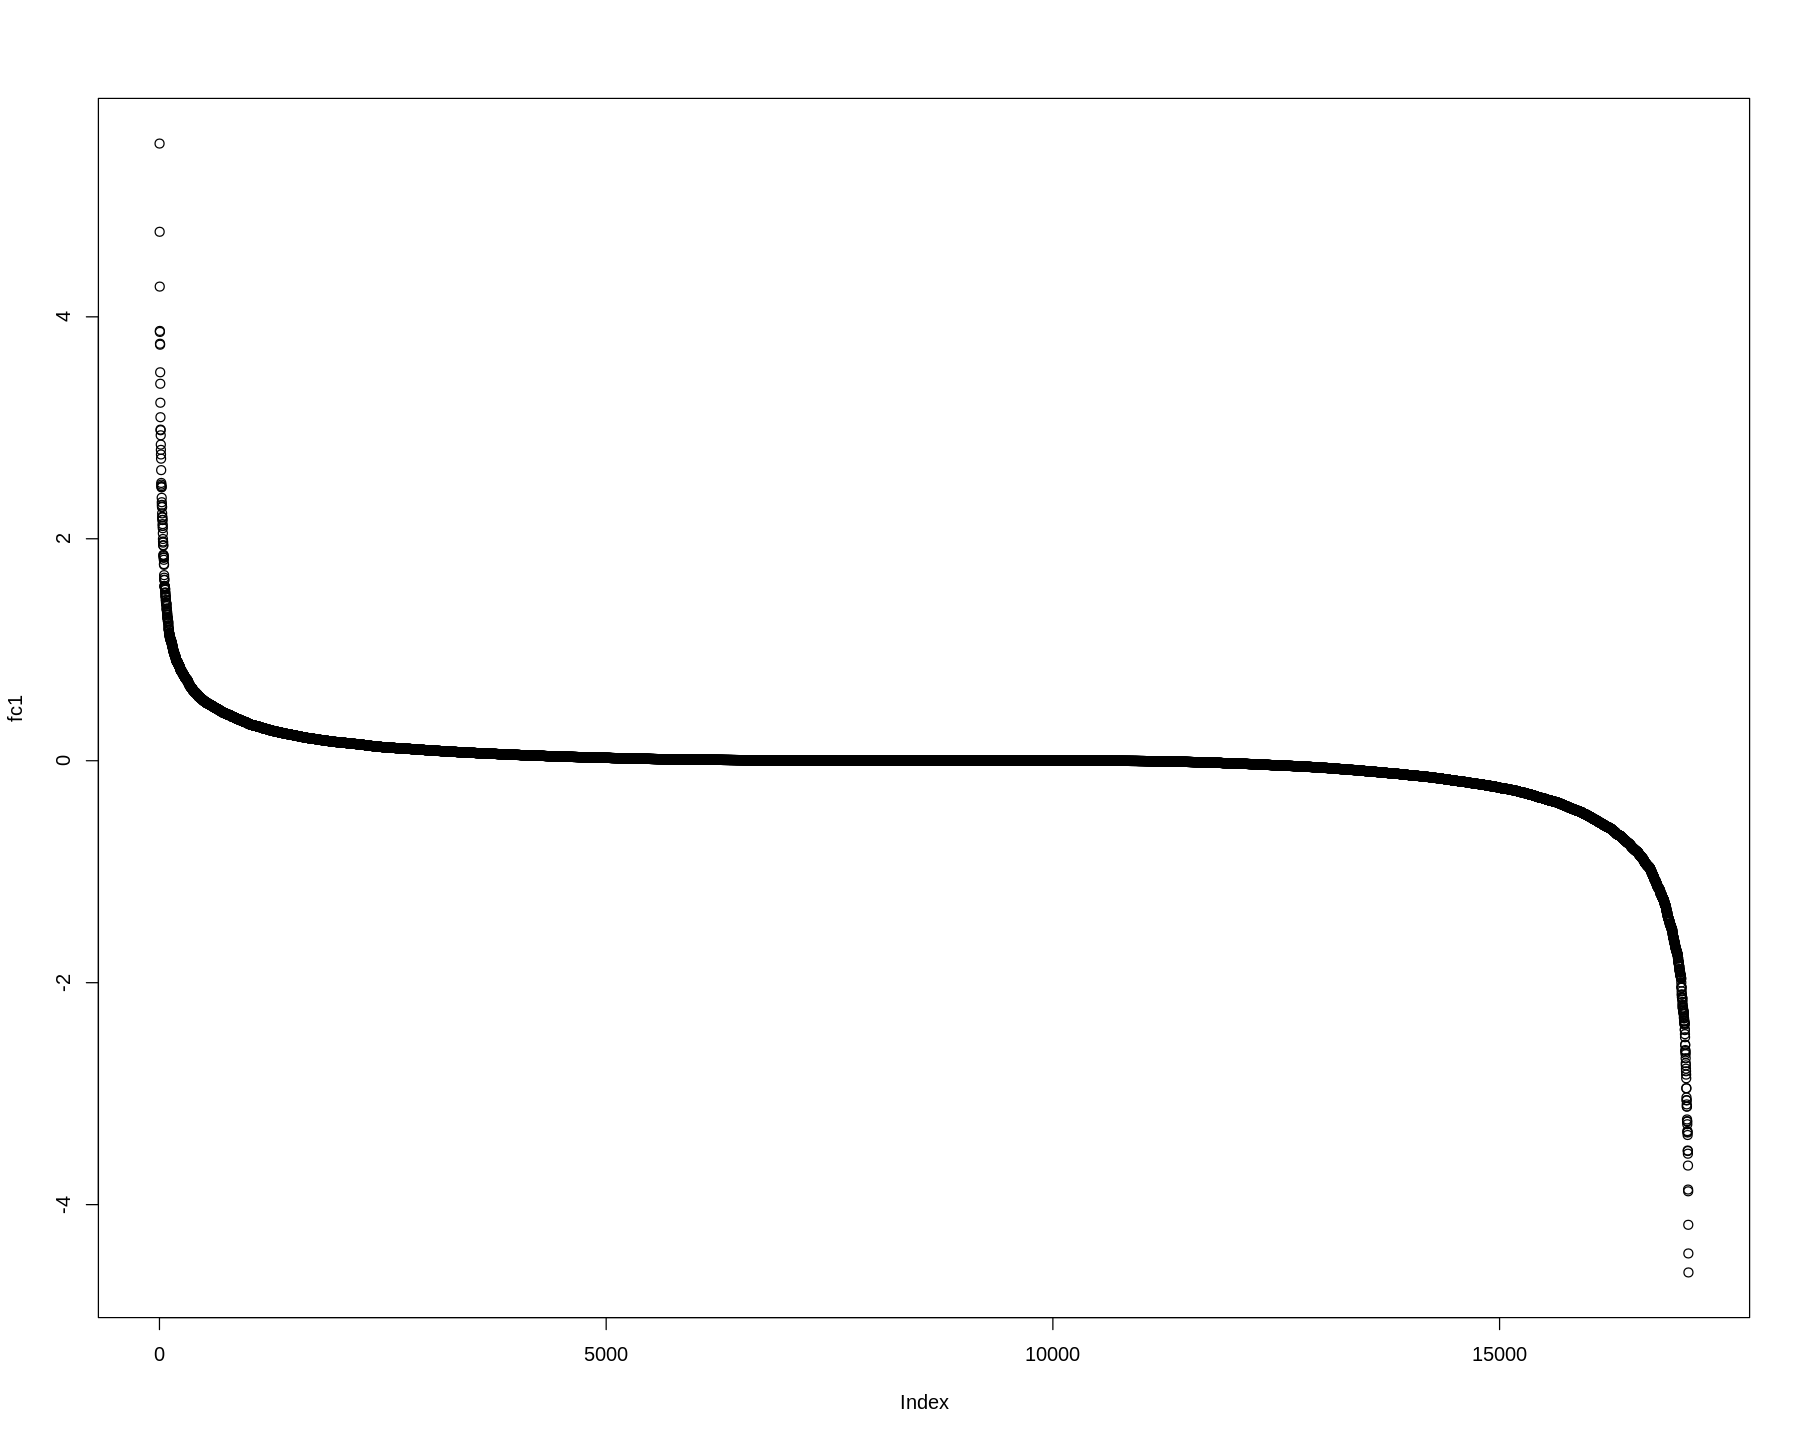

In [ ]:
plot(fc1)

In [ ]:
set.seed(4)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = fc1,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.2% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,0.83310249,0.83310249,0.03625791,0.3352978,0.7907005,39,"Kat7 , Usp22 , Oga , Phf14 , Gtf3c4, Mettl8, Supt7l, Naa40 , Ep300 , Ncoa1"
hdac,0.47028424,0.61557789,0.05830345,0.3759323,0.9805061,73,"Sinhcaf, Sap18 , Jmjd1c , Hdac2 , Rbbp4 , Mta3 , Hey2 , Hint1 , Sall1 , Hdac1 , Rere , Zfp217 , Dmap1 , Gatad2a, Csnk2a1, Tbl1xr1, Rcor2 , Sin3a , Phf12 , Hdac3 , Gatad2b, Rcor3 , Ruvbl1 , Ing3 , Chd4 , Kdm3b"
hdac_sub,0.41478873,0.61557789,0.05586146,0.4214528,1.0032512,41,"Sap18 , Jmjd1c , Hdac2 , Hint1 , Hdac1 , Rere , Zfp217 , Tbl1xr1, Rcor2 , Sin3a , Hdac3 , Rcor3 , Kdm3b"
inflammatory,0.01345952,0.06729758,0.17989040,-0.5018975,-1.2859803,393,"Thbs1 , Fn1 , Axl , Rtn4 , Igfbp4 , Sphk1 , Cd44 , Tgfb1 , Nupr1 , Cyba , Cebpb , Map2k3 , Timp1 , Ext1 , Scn9a , Cd47 , Tnfrsf1a, Ecm1 , Ctnnbip1, Tnip2 , Anxa1 , Nfe2l2 , Nlrp1a , Sdc1 , Gsdmd , Eif2ak1 , Bdkrb1 , B4galt1 , Cspg4 , Ccl2 , Tnip1 , Ptgs1 , Gal , Scyl1 , Ptgir , Tcirg1 , Ly96 , Ptn , Rela , Plgrkt , Ptgs2 , Relb , Il17rc , Notch2 , Mapk8 , Aimp1 , Ndufs4 , Hif1a , Pxk , Ptger1 , Hmgb1 , Sema7a"
nfkb,0.49246231,0.61557789,0.02886978,-0.5150185,-0.9917777,24,"Rela , Irak1, Relb , Akt1 , Malt1"


In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               fc1) + labs(title=sprintf('%s: ES %f, p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$ES,fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
               })

#OSKM

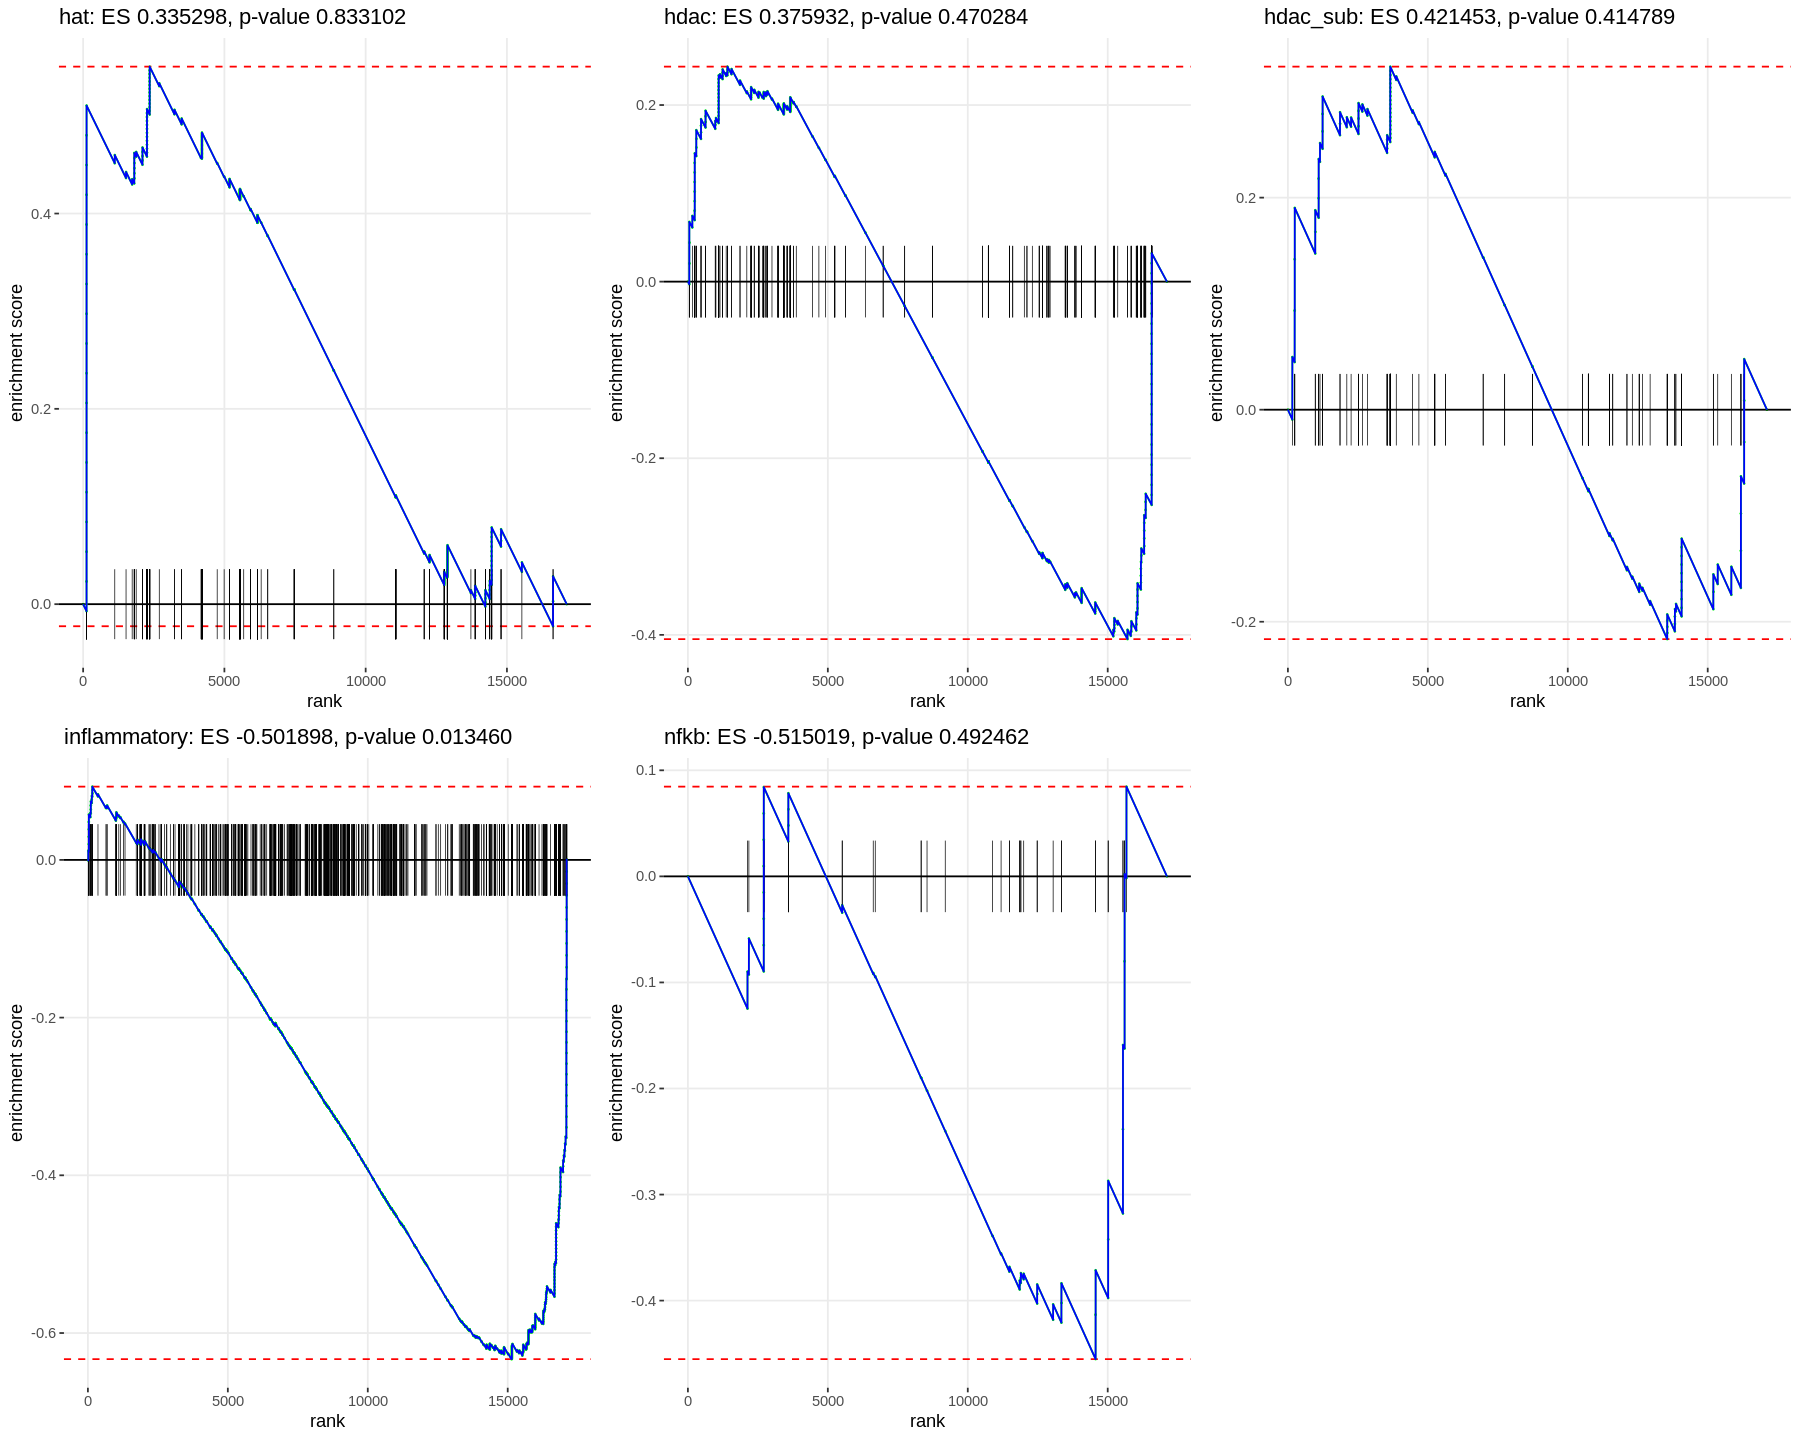

In [ ]:
names(ep) <- names(genes)
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

## Pvalue of each geneset and the color lightblue here represents negative ES scores and coral represents positive

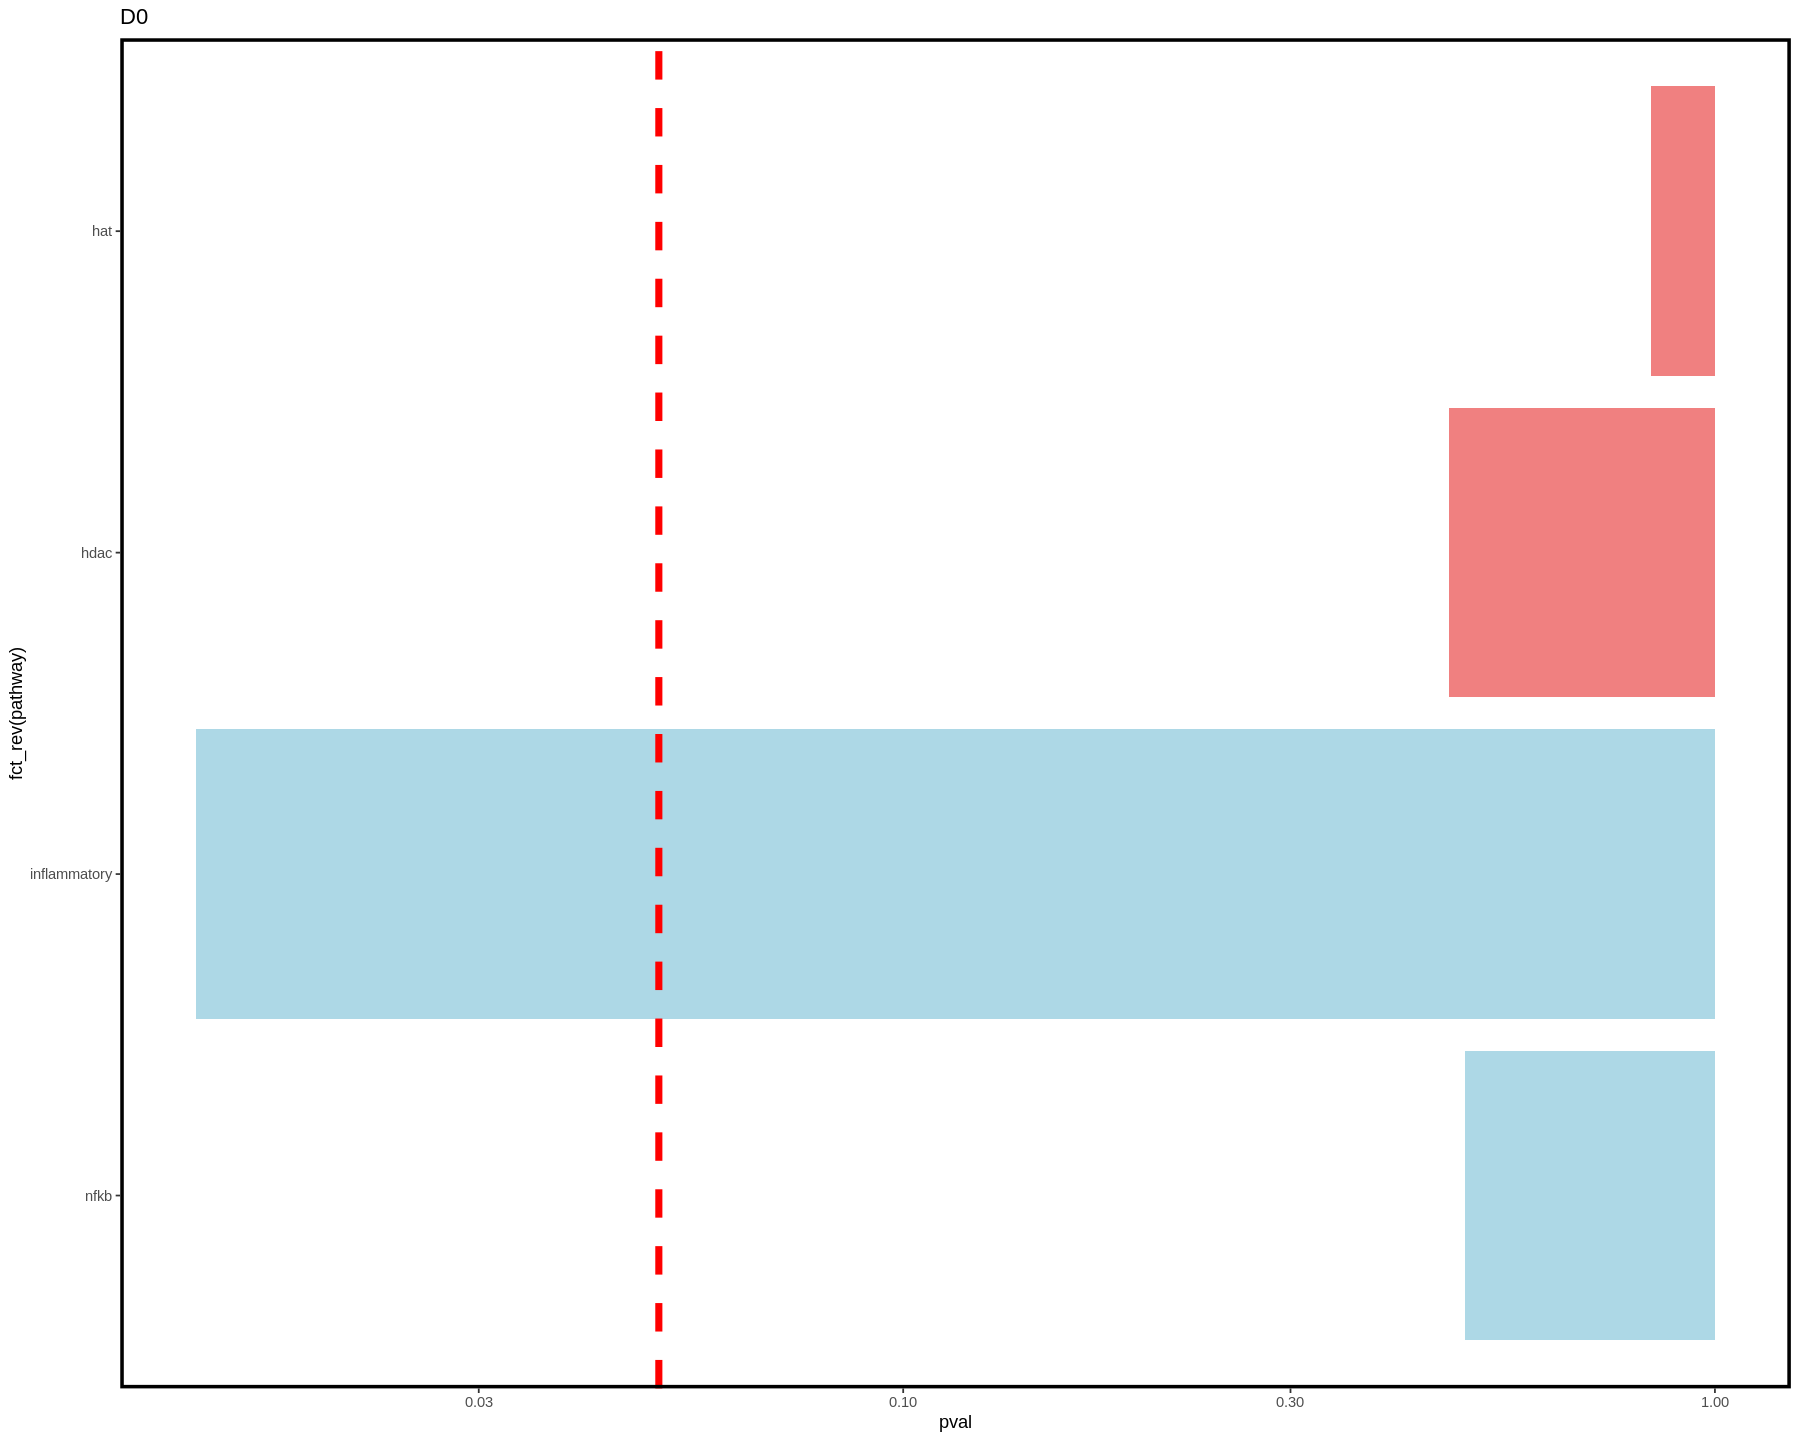

In [ ]:
fgseaRes$ES_score <- ifelse(fgseaRes$ES > 0, "lightcoral", "lightblue")
ggplot(fgseaRes[!grepl('sub', fgseaRes$pathway),],  aes(x = fct_rev(pathway), y = pval, fill = ES_score)) + 
geom_bar(stat = 'identity') + 
coord_flip() +
scale_fill_identity() + 
scale_y_continuous(trans = 'log10',)  + 
geom_hline(yintercept=0.05, color = 'red', linetype='dashed', size = 2) +
 theme_bw() + theme(panel.border = element_rect(colour = 'black', size = 2), panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) +ggtitle('D0')

## Pvalue of each geneset and the color lightcoral here represents negative ES scores and lightblue represents positive

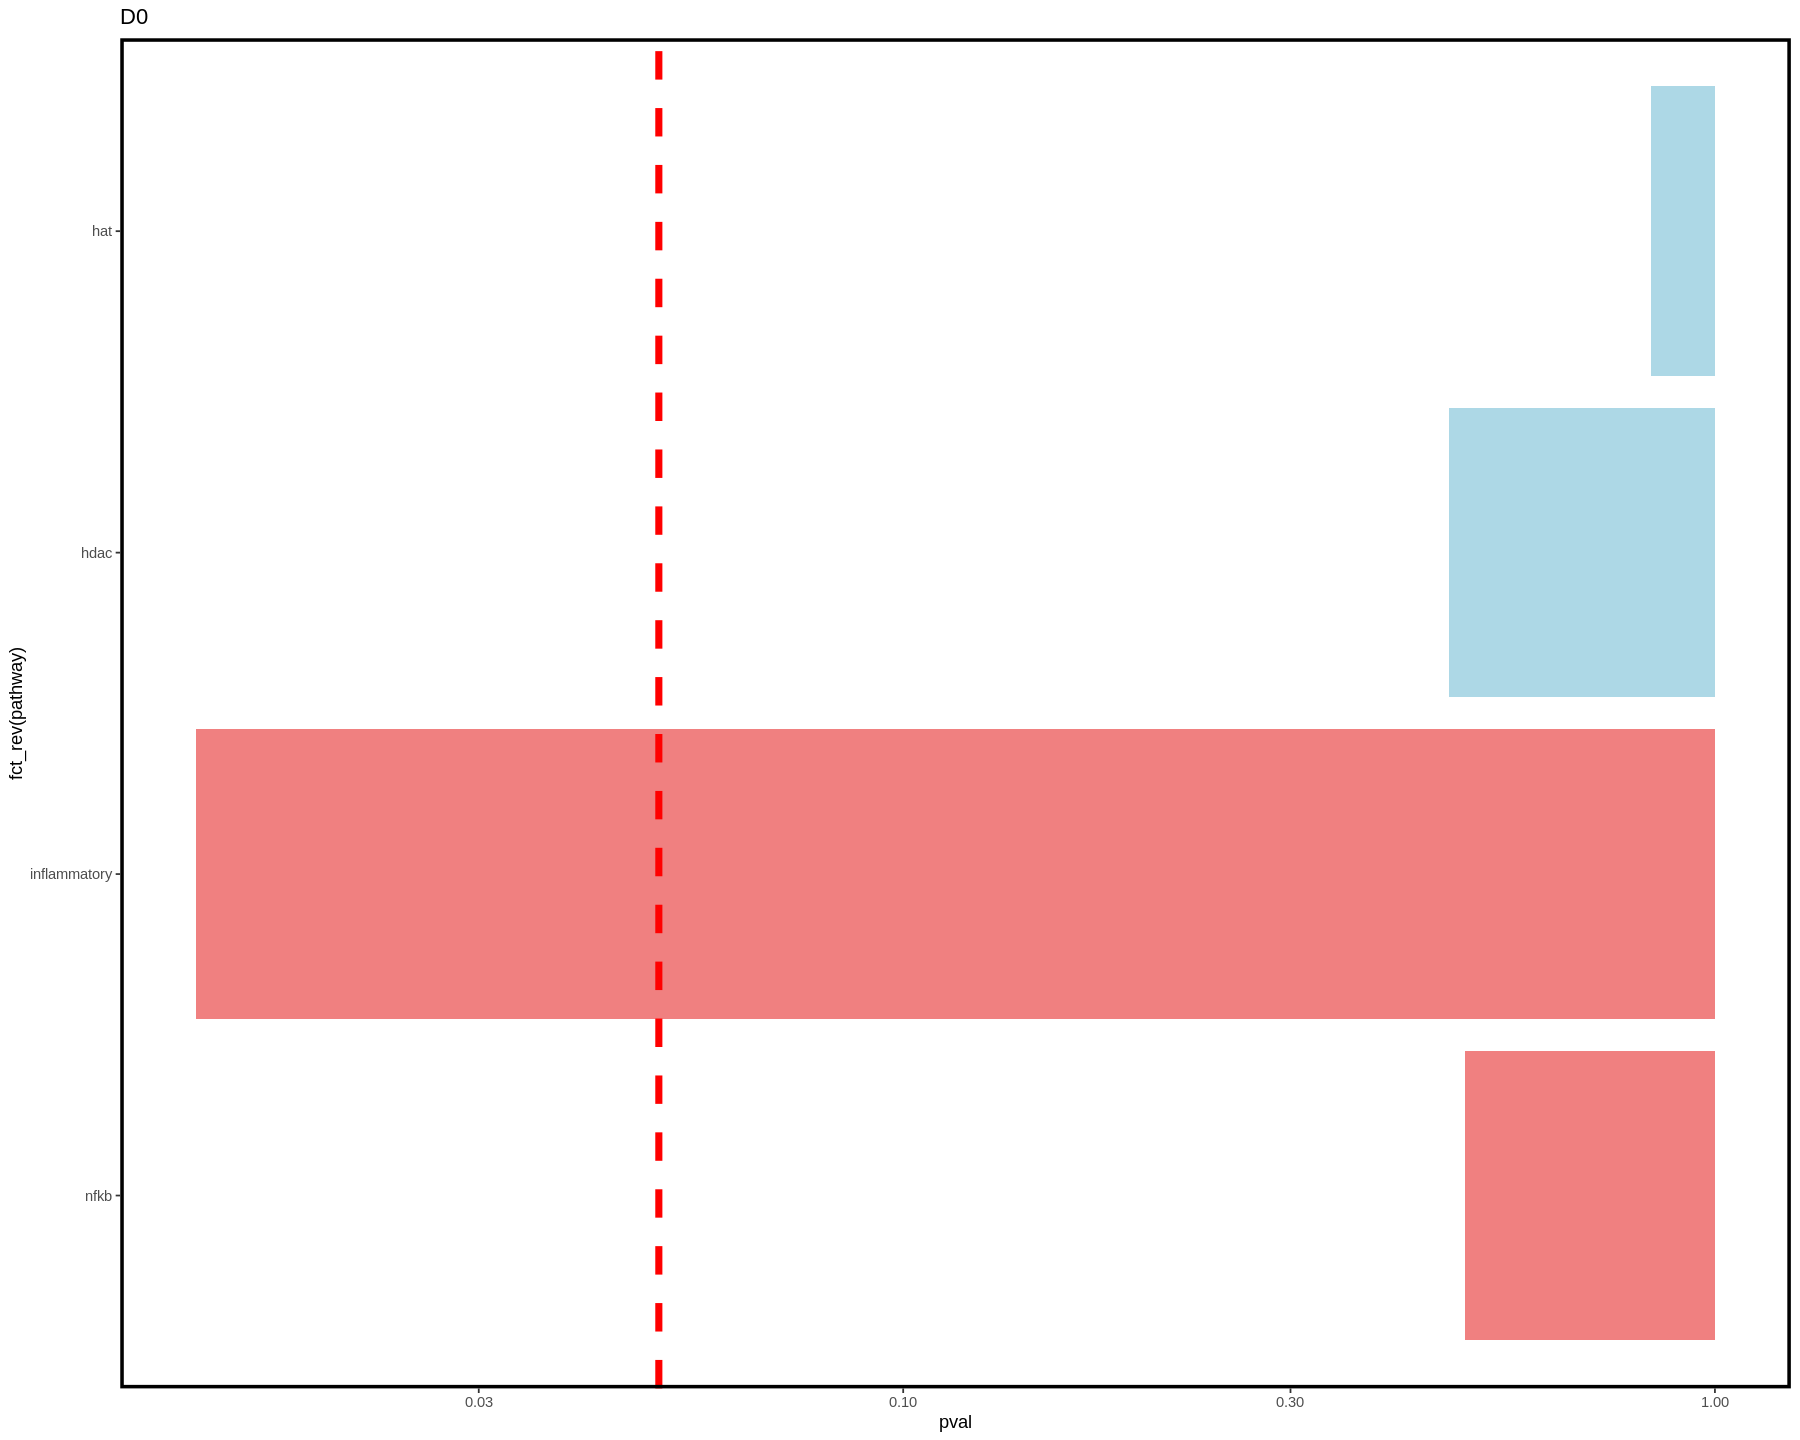

In [ ]:
fgseaRes$ES_score <- ifelse(fgseaRes$ES < 0, "lightcoral", "lightblue")
ggplot(fgseaRes[!grepl('sub', fgseaRes$pathway),],  aes(x = fct_rev(pathway), y = pval, fill = ES_score)) + 
geom_bar(stat = 'identity') + 
coord_flip() +
scale_fill_identity() + 
scale_y_continuous(trans = 'log10',)  + 
geom_hline(yintercept=0.05, color = 'red', linetype='dashed', size = 2) +
 theme_bw() + theme(panel.border = element_rect(colour = 'black', size = 2), panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) +ggtitle('D0')

# Liu iCM


In [ ]:
norm_2 <- t(t(assays(se$Liu)$counts)/colSums(assays(se$Liu)$counts) * median(colSums(assays(se$Liu)$counts))) 

In [ ]:
assays(se$Liu)$normalized_counts <- norm_2

In [ ]:
colData(se$Liu)$Sample <- gsub('_[A-Z][0-9]+','',colData(se$Liu)$sample)

In [ ]:
Sample <- colData(se$Liu)$Sample

In [ ]:
X_2 <- assays(se$Liu)$normalized_counts
Sample <- colData(se$Liu)$Sample
control <- Sample %in% c('C1','C2')
treatment <- Sample %in% c('M1','M2','M3')
pvalues_liu <- mclapply(
  1:nrow(X_2), function(i) wilcox.test(X_2[i, treatment], X_2[i, control], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
fc_liu <- log2(rowMeans(X_2[, treatment])+1) - log2(rowMeans(X_2[, control])+1)
names(pvalues_liu) <- names(fc_liu) <- rowData(se$Liu)$symbol

In [ ]:
res_liu <- data.frame(
  name = rowData(se$Liu)$symbol, 
  fc2 = fc_liu, 
  pvalue = pvalues_liu
)

In [ ]:
head(res_liu)

,name,fc2,pvalue
,<chr>,<dbl>,<dbl>
0610005C13Rik,0610005C13Rik,0.0000000,NaN
0610009B22Rik,0610009B22Rik,0.1797294,5.195868e-01
0610009L18Rik,0610009L18Rik,1.3751628,2.513984e-01
0610010F05Rik,0610010F05Rik,-0.3424773,1.093897e-02
0610010K14Rik,0610010K14Rik,-0.2022048,5.044202e-02
0610012G03Rik,0610012G03Rik,1.1689416,6.065148e-08


#Fold Change of genes iCM

In [ ]:
l2fc <- res_liu$fc2

In [ ]:
names(l2fc) <- rownames(res_liu)

In [ ]:
l2fc <- na.omit(l2fc)
l2fc <- sort(l2fc, decreasing = TRUE)

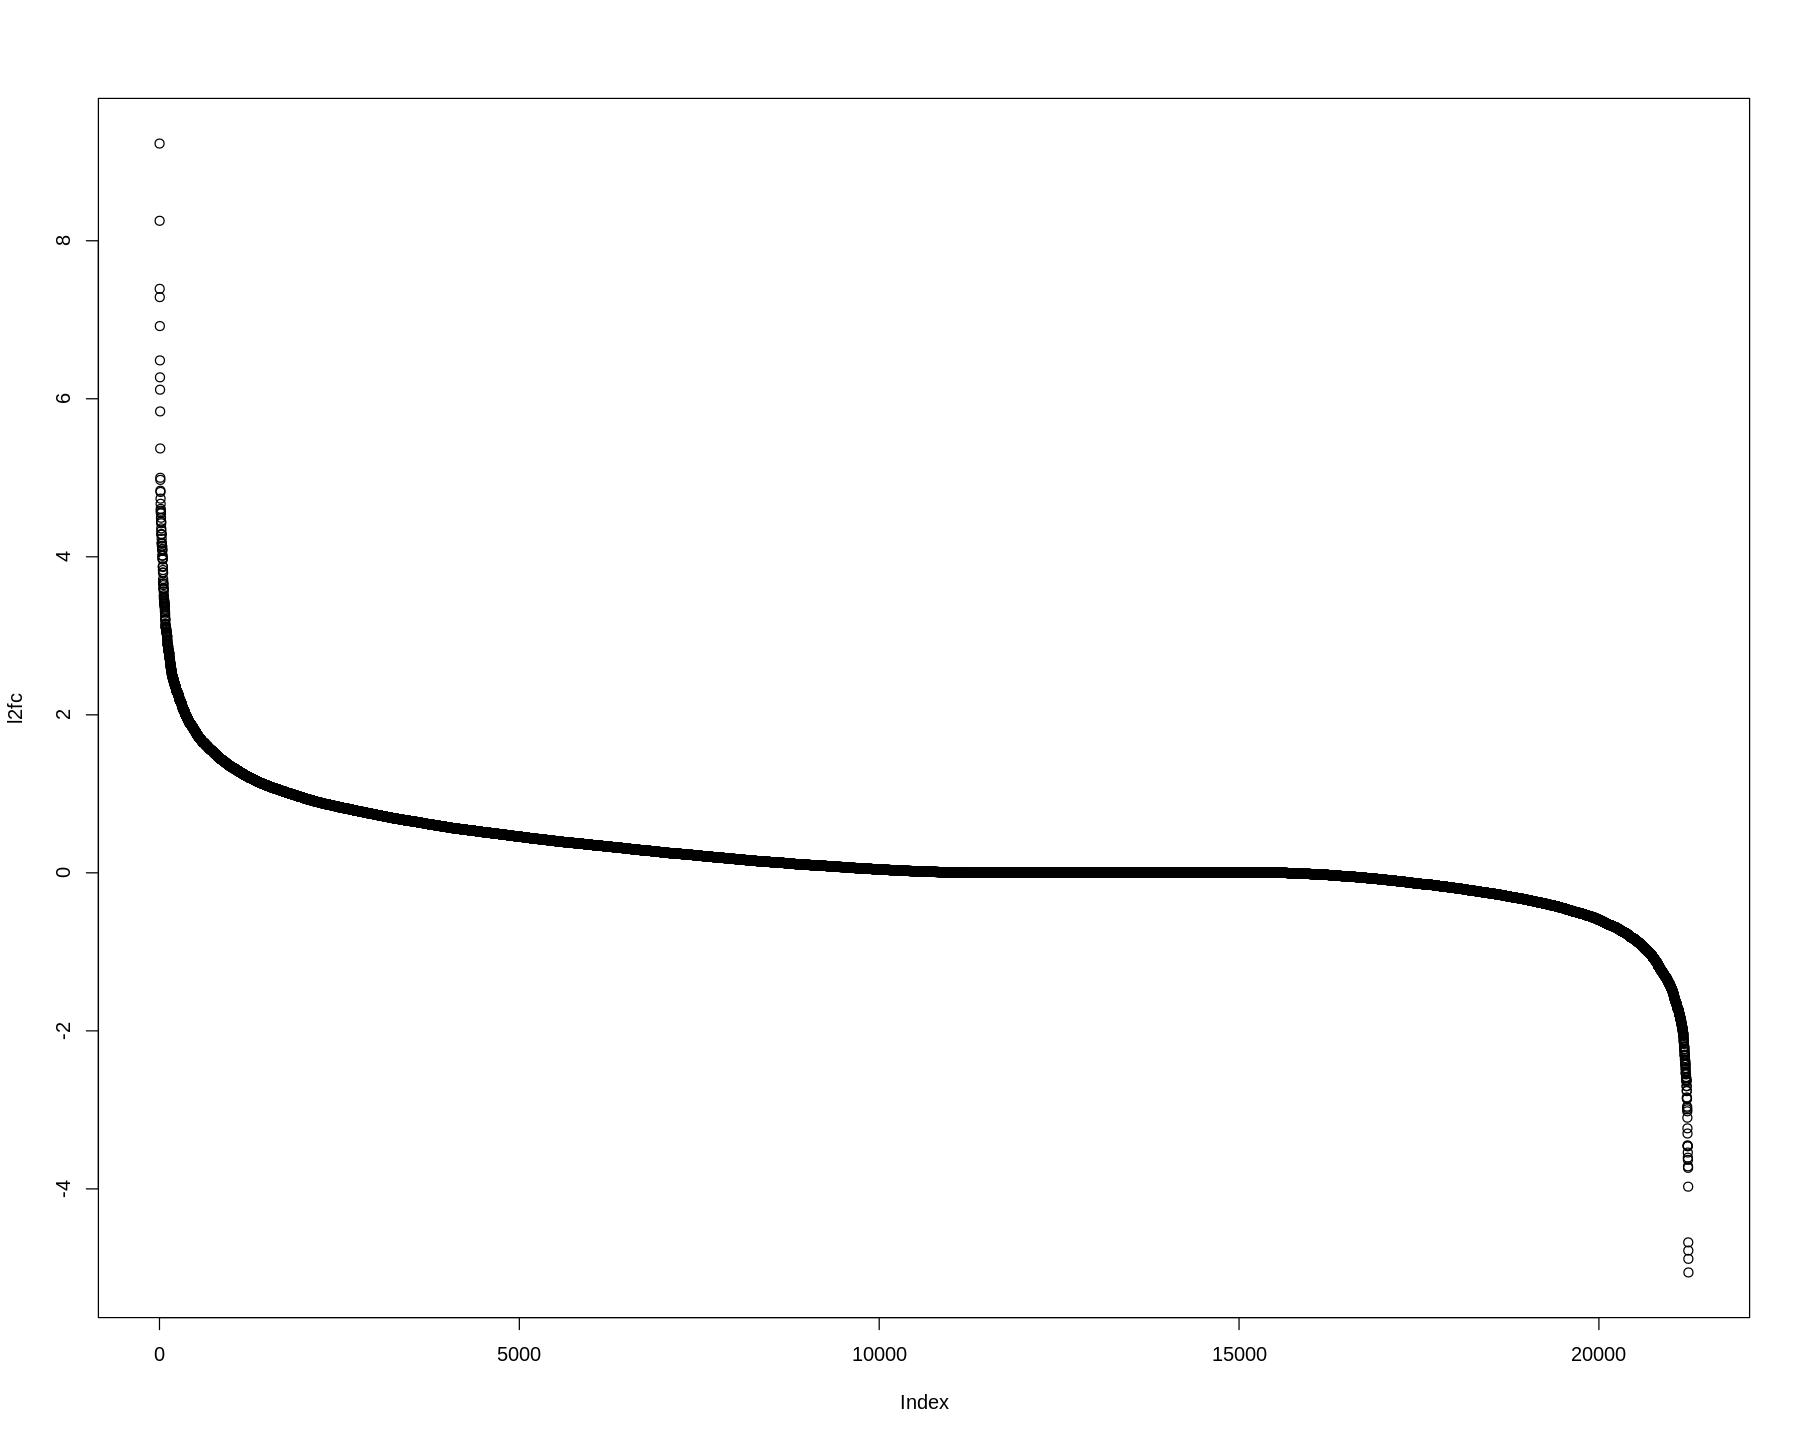

In [ ]:
plot(l2fc)

In [ ]:
set.seed(2)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = l2fc,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.99% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,0.41258902,0.5157363,0.02725769,0.4609478,1.0527542,38,"Naa40 , Kat8 , Kat6a , Kat7 , Gtf3c4, Kat2a , Taf10 , Brpf1 , Ep300 , Kat5 , Med24 , Hat1 , Mcm3ap, Kat2b , Crebbp, Epc1 , Ncoa1 , Taf1 , Tada3 , Phf14 , Atf2 , Brpf3 , Supt7l"
hdac,0.14212548,0.2368758,0.05207009,0.4903181,1.2090315,73,"Hdac9 , Hdac6 , Chd3 , Hdac11 , Mta2 , Trerf1 , Hdac10 , Hdac7 , Ncor2 , Trrap , Arhgef10l, Zfp217 , Rcor1 , Sap130 , Dnttip1 , Kdm3a , Satb2 , Anp32e , Chd4 , Mbd3 , Sin3a , Brd8 , Hdac5 , Phf21a , Ep400 , Gatad2b , Phf12 , Hdac8 , Sap18 , Kat5 , Sap30l , Hdac4 , Kdm3b , Hr , Mta1 , Brms1 , Tbl1xr1 , Zbtb7a , Nrip1 , Rere"
hdac_sub,0.08979034,0.2244758,0.06980788,0.5614614,1.2949976,41,"Hdac9 , Hdac6 , Hdac11 , Mta2 , Trerf1 , Hdac10 , Hdac7 , Ncor2 , Arhgef10l, Zfp217 , Rcor1 , Dnttip1 , Kdm3a , Satb2 , Sin3a , Hdac5 , Phf21a , Hdac8 , Sap18 , Sap30l , Hdac4 , Kdm3b , Hr , Tbl1xr1 , Nrip1 , Rere"
inflammatory,0.00400080,0.0200040,0.32603262,0.4616901,1.2283449,456,"Csrp3 , Ccr5 , Camk1d , Serpina3n, S1pr3 , Hdac9 , Il1rn , Ppbp , Pla2g7 , Adam8 , Ccl8 , Ccr6 , Fpr2 , Ccl5 , Tlr13 , Cd5l , Tlr8 , Syk , Ptgir , Aif1 , Ptgfr , Pik3cd , Csf1r , Trem2 , Nlrp1a , C3ar1 , C5ar1 , Cyp26b1 , Fcer1g , Btk , Itih4 , Tnf , Cd68 , Fcgr1 , Agtr1b , Tlr7 , Havcr2 , Alox5 , Irf5 , Pld4 , Cd14 , Stab1 , Pf4 , Cd180 , Ly86 , Ccl9 , Alox5ap , Cybb , Unc13d , Pparg , Ptger2 , Dab2ip , Cxcl3 , F8 , Itgam , Itgb2 , Slc11a1 , Traf3ip2 , Pik3cg , Nlrc4 , Smad1 , Slamf8 , Fcgr3 , Hmox1 , Tcirg1 , Ccr1 , Naip5 , Cxcl10 , Ticam2 , Ccl3 , Ulk4 , Mapkapk2 , Bdkrb1 , Tusc2 , Cd300a , C4b , Ndst1 , Il17ra , Pycard , Ccl4 , Hk1 , Mylk3 , Themis2 , Zc3h12a , Hdac7 , Pnma1 , Nlrp10 , Rps6ka5 , Naip2 , C5ar2 , Bmp2 , Nfkbid , Psen2 , Cxcr2 , Prkcz , P2rx7 , Ncf1 , Stat5b , Cnr2 , Serpinf2 , Cspg4 , Casp6 , Ptafr , Adam17 , Lta , Tnip1 , Smpdl3b , Stard7 , Ecm1 , Cxcl11 , Ephb6 , Loxl3 , Naip6 , Bcl6 , Clec7a , Akt1 , Mapk8 , Slamf1 , Ap3b1"
nfkb,0.86004728,0.8600473,0.01248861,0.3329208,0.7307093,28,"Malt1 , Traf4 , Ikbke , Nfkb2 , Akt1 , Rel , Irak1 , Traf2 , Tlr4 , Map3k7, Dicer1, Rela , Ppp4c , Ikbkg , Zfp91"


In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               l2fc) + labs(title=sprintf('%s: ES %f, p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$ES,fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
               })

In [ ]:
names(ep) <- names(genes)

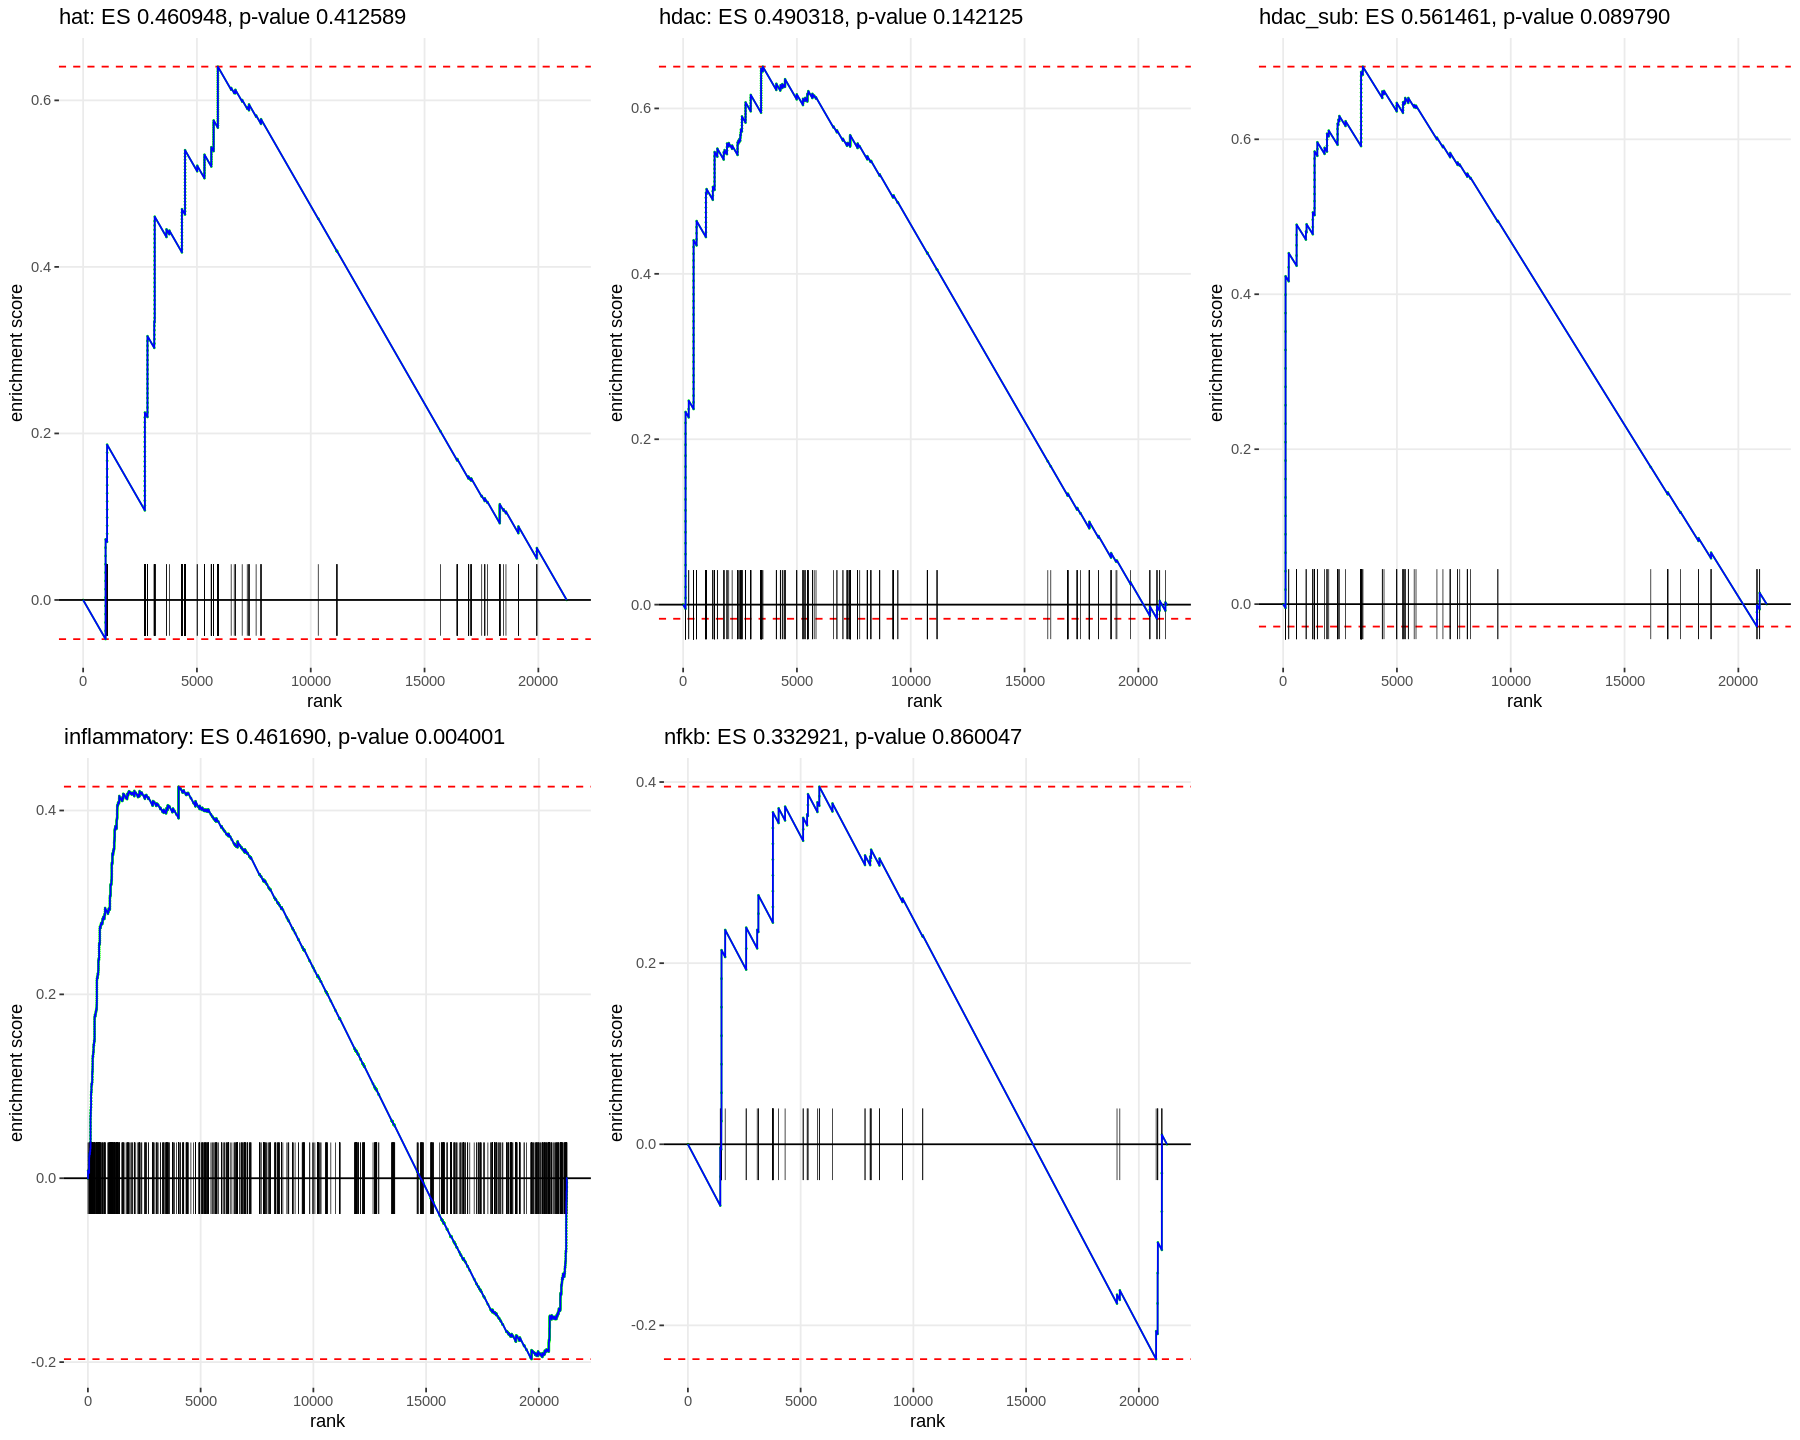

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

## Pvalue of each geneset and the color lightblue here represents positive ES scores

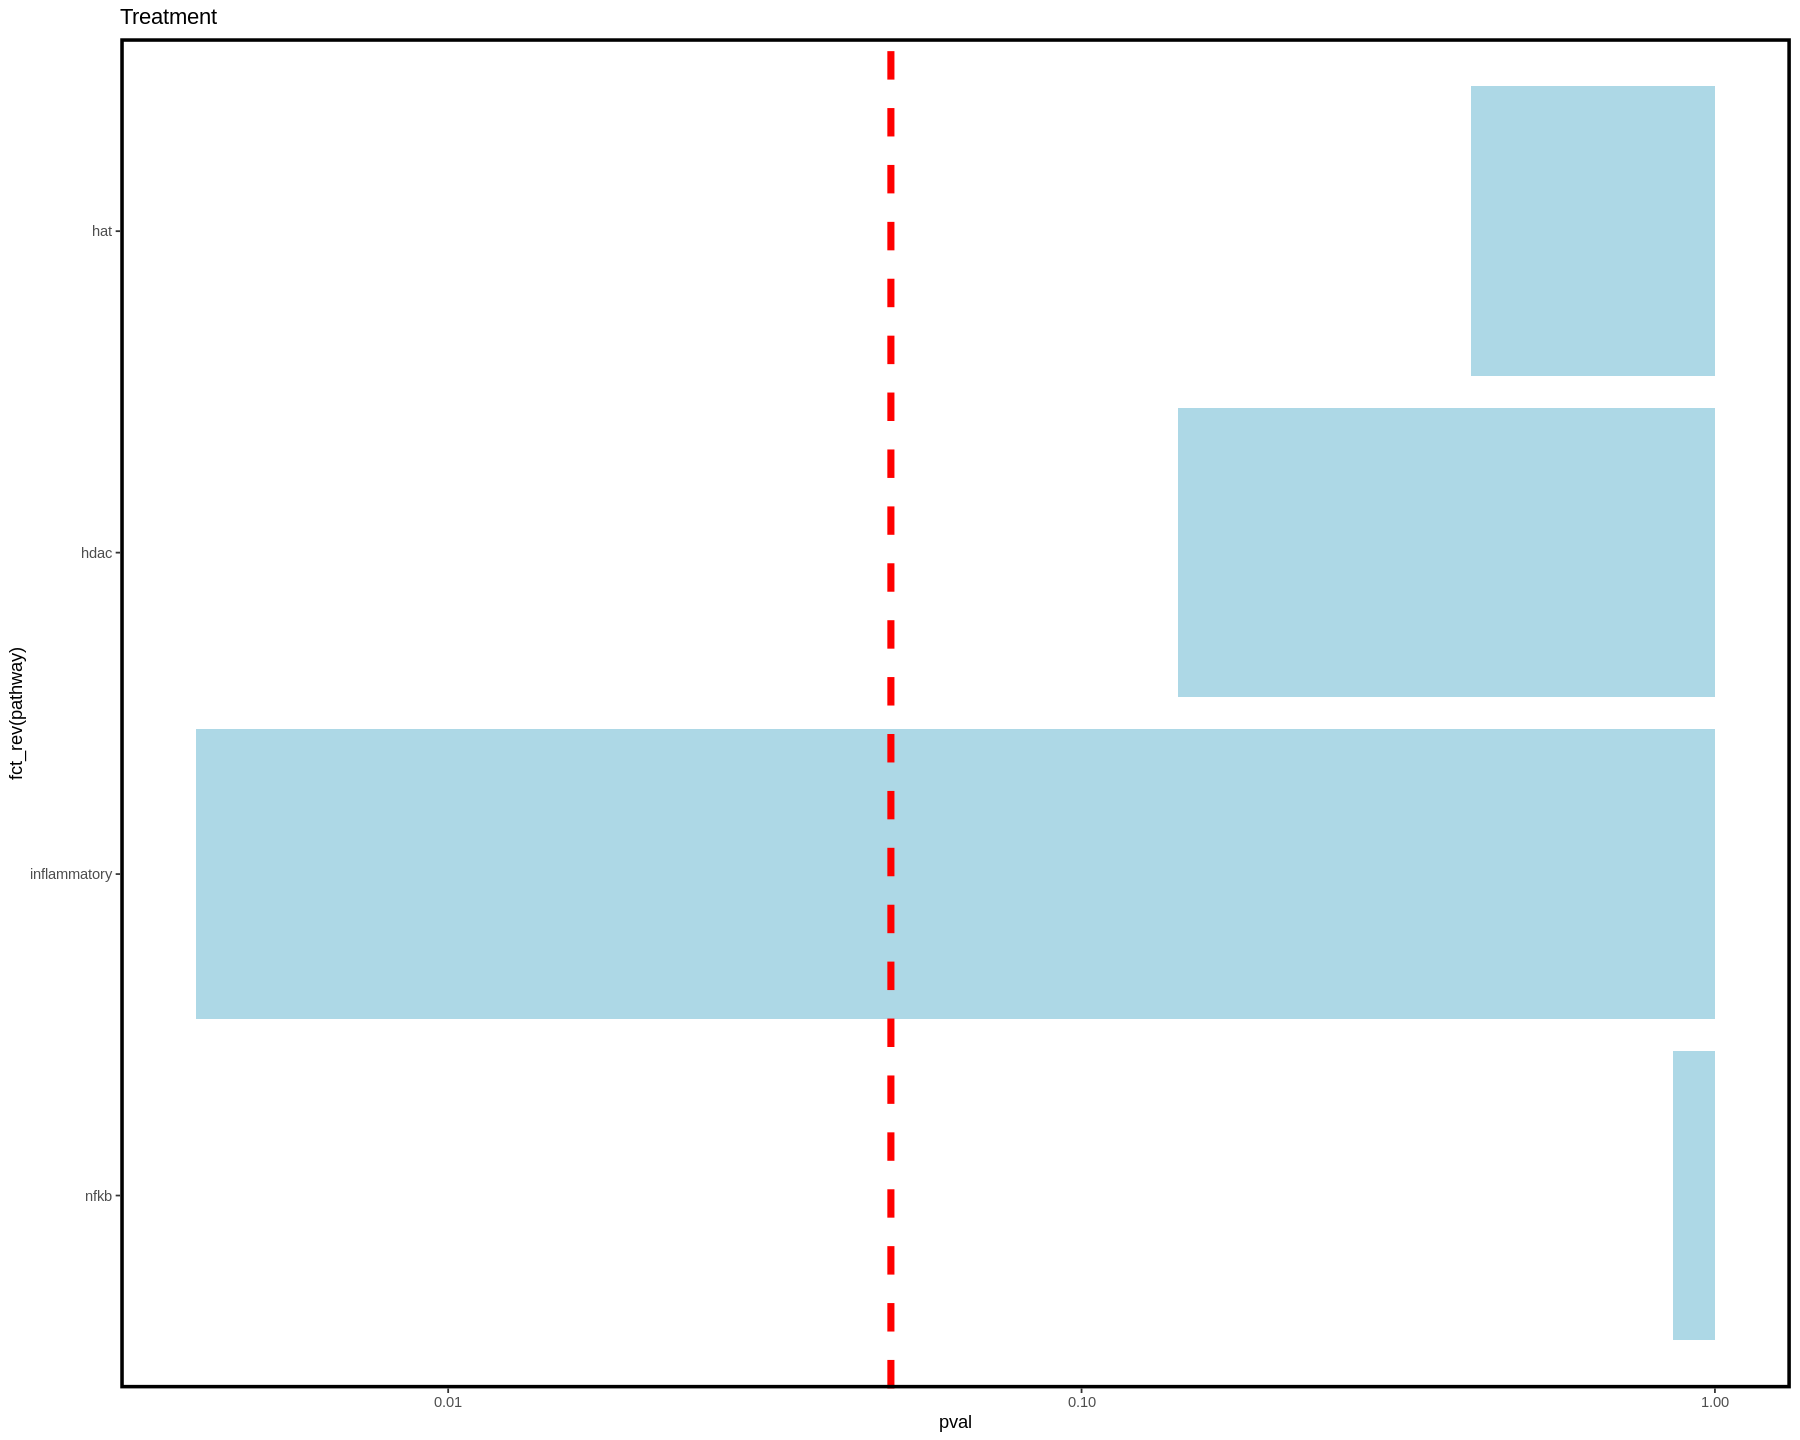

In [ ]:
fgseaRes$ES_score <- ifelse(fgseaRes$ES < 0, "lightcoral", "lightblue")
ggplot(fgseaRes[!grepl('sub', fgseaRes$pathway),],  aes(x = fct_rev(pathway), y = pval, fill = ES_score)) + 
geom_bar(stat = 'identity') + 
coord_flip() +
scale_fill_identity() + 
scale_y_continuous(trans = 'log10',)  + 
geom_hline(yintercept=0.05, color = 'red', linetype='dashed', size = 2) +
 theme_bw() + theme(panel.border = element_rect(colour = 'black', size = 2), panel.grid.major = element_blank(),
panel.grid.minor = element_blank()) +ggtitle('Treatment')

We found that inflammatory response pathways were up-regulated during cardiac reprogramming, but down-regulated in OSKM induced reprogramming and Ascl1 induced neuronal reprogramming, compared with the undifferentiated MEFs.

In [ ]:
Sys.time() - start_time0

Time difference of 31.17605 mins

In [ ]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] SingleCellExperiment_1.14.1              
 [2] scales_1.1.1                             
 [3] forcats_0.5.1                            
 [4] biomaRt_2.48.3                           
 [5] cowplot_1.1.1                            